In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")

random_state = 1701

Because the dataset was very large and model fitting with all 100,000+ rows (even after dropping those with missing data) was impractically slow on my computer, I decided to limit the dataset to campaigns launched in 2024 or 2025 (which would be most relevant to someone currently looking to launch a campaign, as trends in funding may have changed over time). I also capped the goal amount at $100,000 USD to remove a few outliers which may have distorted results otherwise.

In [2]:
KS = pd.read_csv('Full_Kickstarter_data.csv')[['state_num', 'state_binary', 'usd_goal', 'parent_category', 'sub_category', 'backing_action_count', 'has_video', 'creator_prev_projects', 'launch_day', 'hours_from_noon', 'launch_month', 'country', 'prelaunch_activated', 'blurb_length', 'staff_pick', 'days_active']]

In [3]:
KS.dropna(subset=['parent_category', 'sub_category'], inplace=True)

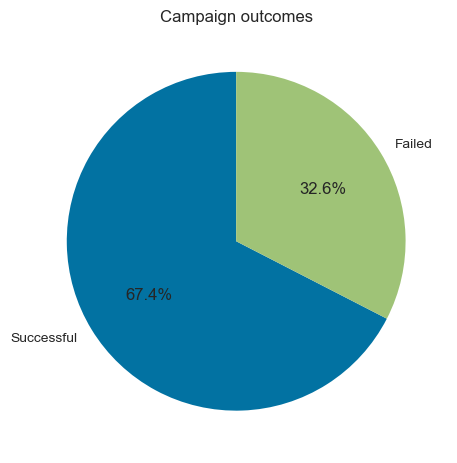

In [4]:
plt.rcParams['axes.grid'] = False # Disable grid lines
outcomes = KS['state_binary'].value_counts()
plt.pie(outcomes, labels = outcomes.index, autopct ='%1.1f%%', startangle=90)
plt.title('Campaign outcomes')
plt.show()

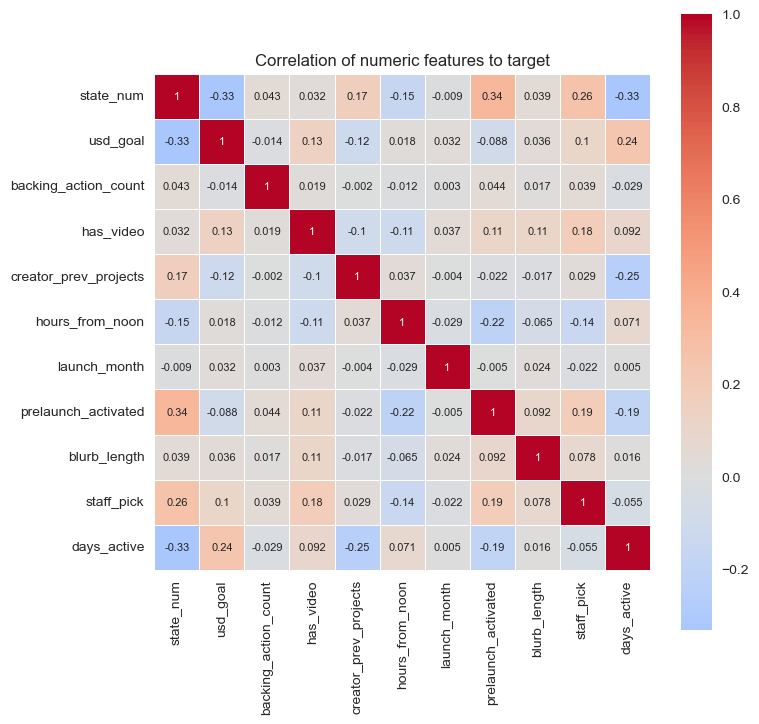

In [5]:
numeric_vars = KS.copy().drop(['sub_category', 'parent_category', 'country', 'launch_day', 'state_binary'], axis=1)
pd.options.mode.chained_assignment = None
correlation_matrix = numeric_vars.corr().round(3)

fig = plt.figure(figsize = (8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, annot_kws={"fontsize":8})
plt.title("Correlation of numeric features to target")
plt.show()

Because there doesn't appear to be a linear relationship between month and campaign outcome, I treated it as a discrete rather than numeric feature.
(To make the proportion of success/failure clearer, plots show percentages rather than absolute counts -- it's difficult to compare when bars are different heights.)

Text(0.5, 1.0, 'Outcome by month launched')

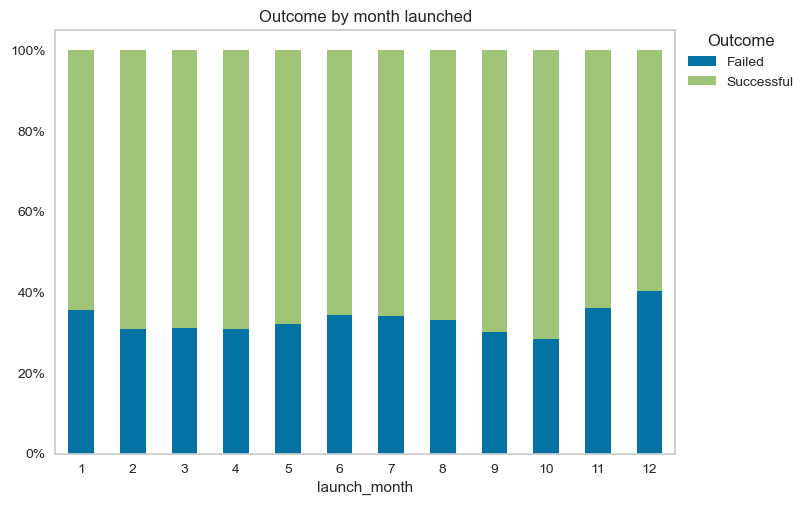

In [6]:
ax = pd.crosstab(KS['launch_month'], KS['state_binary'], normalize='index').plot(kind='bar', stacked=True)
ax.legend(title='Outcome', bbox_to_anchor=(1, 1.02), loc='upper left')
ax.tick_params(axis='x', rotation=0)
vals=ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.title("Outcome by month launched")

I converted launch hour into an "hours from noon" feature in preprocessing because I noticed that a higher proportion of successful campaigns were launched during business hours.

Text(0.5, 1.0, 'Outcome by time launched (hours from noon)')

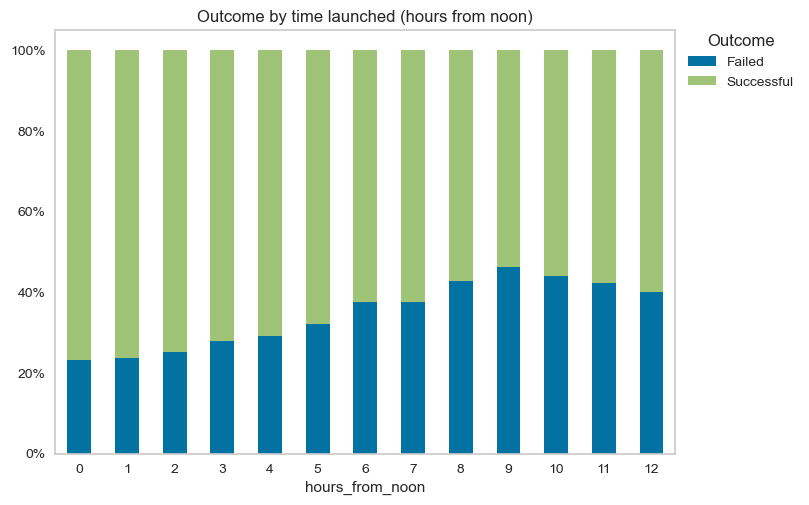

In [7]:
ax = pd.crosstab(KS['hours_from_noon'], KS['state_binary'], normalize='index').plot(kind='bar', stacked=True)
ax.legend(title='Outcome', bbox_to_anchor=(1, 1.02), loc='upper left')
ax.tick_params(axis='x', rotation=0)
vals=ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.title("Outcome by time launched (hours from noon)")

Different project categories have very different success rates. There's variation by subcategory as well, but there are too many subcategories to create a readable plot.

Text(0.5, 1.0, 'Outcome by project category')

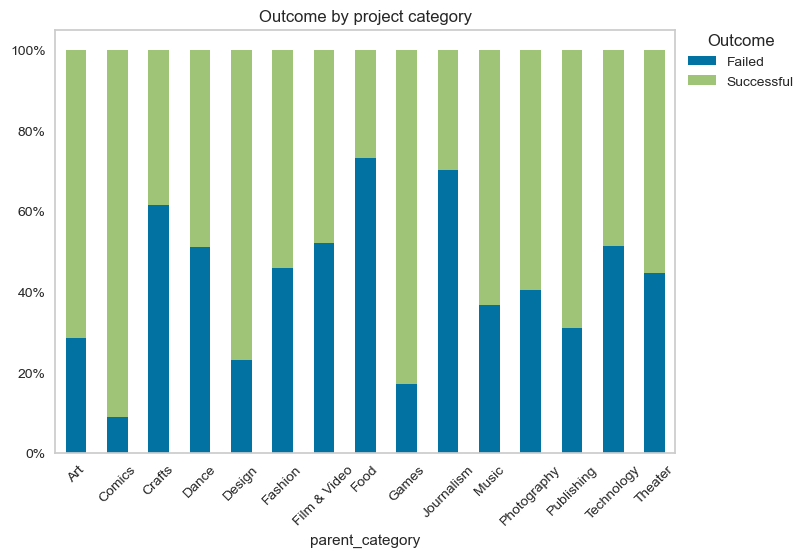

In [8]:
ax = pd.crosstab(KS['parent_category'], KS['state_binary'], normalize='index').plot(kind='bar', stacked=True)
ax.legend(title='Outcome', bbox_to_anchor=(1, 1.02), loc='upper left')
ax.tick_params(axis='x', rotation=45)
vals=ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.title("Outcome by project category")

Different countries also have quite different success rates.

Text(0.5, 1.0, 'Outcome by country')

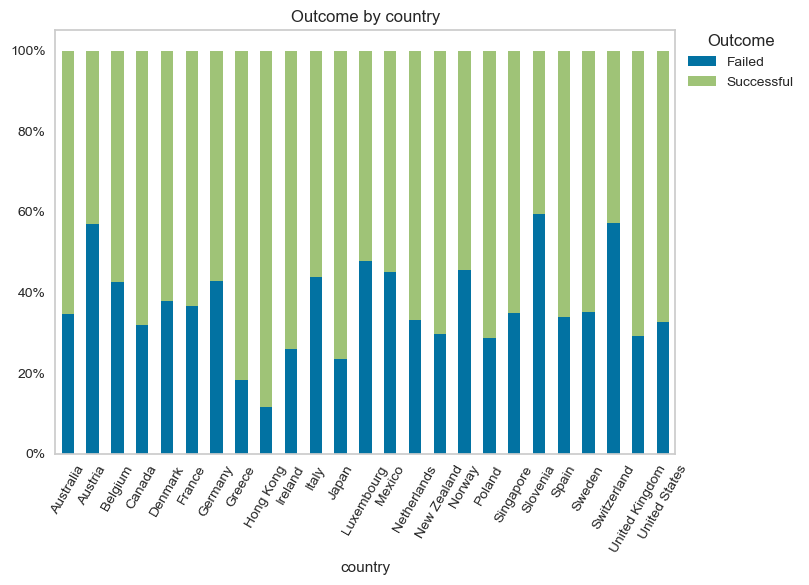

In [9]:
ax = pd.crosstab(KS['country'], KS['state_binary'], normalize='index').plot(kind='bar', stacked=True)
ax.legend(title='Outcome', bbox_to_anchor=(1, 1.02), loc='upper left')
ax.tick_params(axis='x', rotation=60)
vals=ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.title("Outcome by country")

The distribution of funding goals is very skewed. I chose to handle this using a RobustScaler, but log-scaling funding goal would probably also have been effective.

Text(0.5, 1.0, 'Funding goal distribution')

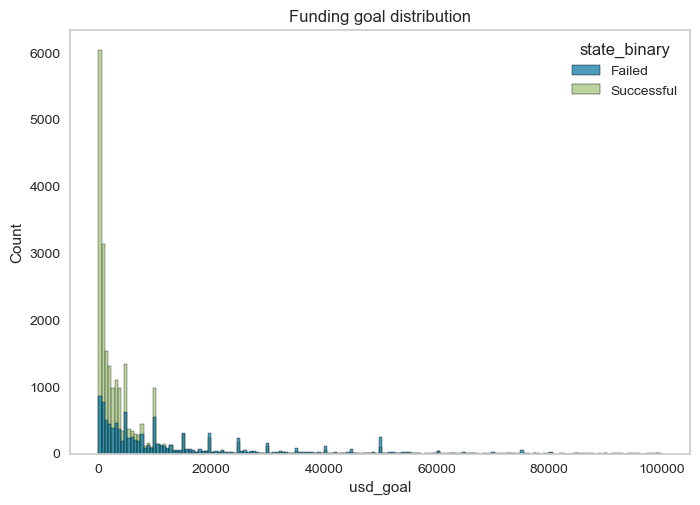

In [10]:
fig = plt.figure()
ax = sns.histplot(data=KS, x="usd_goal", hue='state_binary', alpha=0.7)
plt.title("Funding goal distribution")

Looking at a log-scaled plot, we can see that higher funding goals do tend to be associated with less chance of success.

Text(0.5, 1.0, 'Funding goal - Log scaled for clearer view of outcome breakdown')

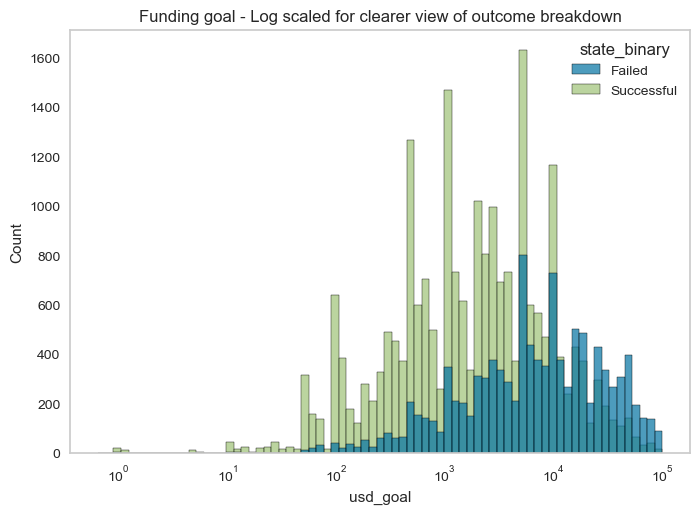

In [11]:
fig = plt.figure()
ax = sns.histplot(data=KS, x="usd_goal", hue='state_binary', alpha=0.7, log_scale=True)
plt.title("Funding goal - Log scaled for clearer view of outcome breakdown")

Text(0.5, 1.0, 'Campaign length distribution')

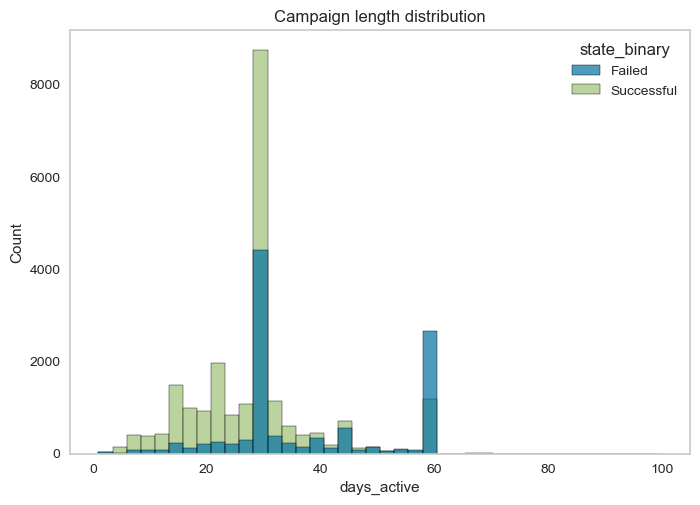

In [12]:
ax = sns.histplot(data=KS, x="days_active", hue='state_binary', alpha=0.7, bins=40)
plt.title("Campaign length distribution")

# Data preprocessing, model fitting

The data file I created through preprocessing included both text (state_binary) and numeric (state_num) versions of the target variable for convenience in visualization. For model fitting, we want only the numeric version.

In [13]:
KS_processed = KS.copy().drop('state_binary', axis=1)

In [14]:
y = KS_processed['state_num']
X = KS_processed.drop('state_num', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

In [15]:
numeric_columns = ['blurb_length',  'hours_from_noon', 'creator_prev_projects', 'usd_goal', 'backing_action_count', 'days_active']
categorical_columns = list(set(KS_processed.columns) - set(numeric_columns) - set(['state_num']))

ct = ColumnTransformer([("text_preprocess", OneHotEncoder(drop='first', sparse_output=False, max_categories=30), categorical_columns),
    ("num_preprocess", RobustScaler(), numeric_columns)],
    verbose_feature_names_out = False
    )
ct.set_output(transform='pandas')
pipe = Pipeline(steps=[('onehot', ct)])
X_train_scaled = pipe.fit_transform(X_train)
X_test_scaled = pipe.transform(X_test)

In [16]:
def calculate_cv_metrics(X_train_scaled, y_train, model_dict):
  kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = random_state)
  results = {}
  for m in model_dict:
    print(f"Cross-validating {m}")
    model = model_dict[m]
    cv_score = cross_validate(model, X_train_scaled, y_train, cv=kfold, scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
    results[m] = {'Avg accuracy': np.mean(cv_score['test_accuracy']).round(4),
                  'Avg precision': np.mean(cv_score['test_precision_weighted']).round(4),
                  'Avg recall': np.mean(cv_score['test_recall_weighted']).round(4),
                  'Avg F1 score':np.mean(cv_score['test_f1_weighted']).round(4)}
    for score, val in results[m].items():
      print(f'{score}: {val}\n')
  return results

def calculate_test_metrics(X_train_scaled, X_test_scaled, y_train, y_test, model_dict):
  results = pd.DataFrame({})
  for m in model_dict:
    model = model_dict[m]
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, target_names=['Failed', 'Successful'], output_dict=True)
    print(f'Classification report for {m}:\n')
    print(classification_report(y_test, y_pred, target_names=['Failed', 'Successful']))
    results[m] = {'accuracy':report['accuracy'], 'precision':report['weighted avg']['precision'], 'recall':report['weighted avg']['recall'], 'F1 score':report['weighted avg']['f1-score']}
  return results

This takes a while to run. I decided to start with k-values below 30 (and a higher step size) to see the trends before committing to running more tests -- CV is slow on my machine even with only 5 folds, especially for high k.

In [17]:
k_range = range(1,30,4)
train_scores, val_scores = validation_curve(KNeighborsClassifier(), X_train_scaled, y_train, param_name = 'n_neighbors', param_range=k_range, cv = 5, scoring = 'accuracy', n_jobs = -1 )

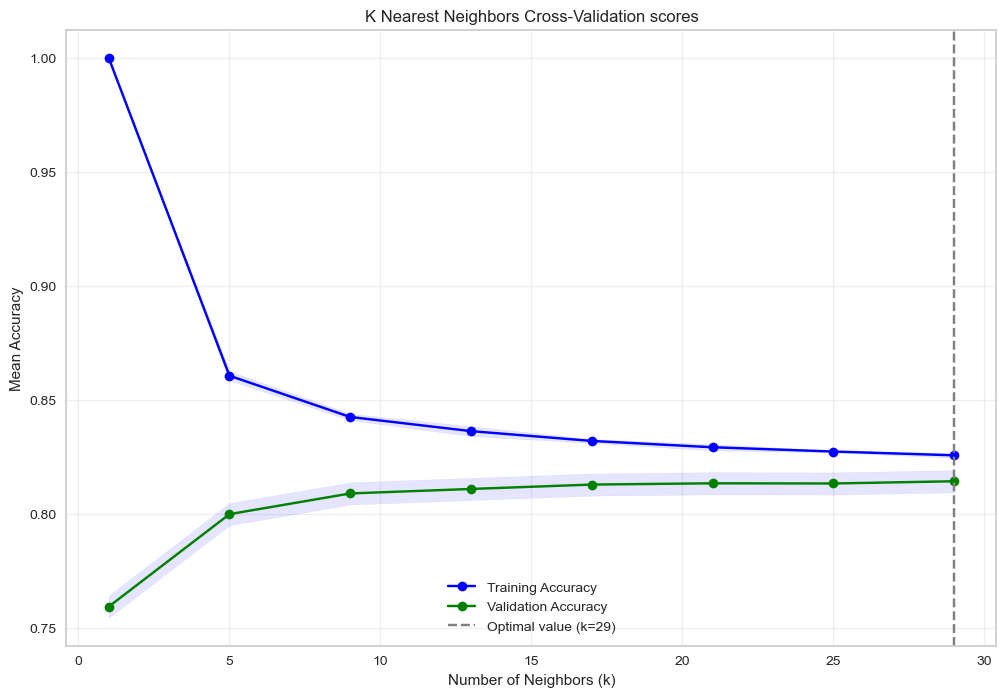

In [18]:
# Calculate the mean and std for all validation scores
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
val_mean = np.mean(val_scores, axis = 1)
val_std = np.mean(np.std(val_scores, axis = 1))

optimal_k = k_range[np.argmax(val_mean)]

# Plot validation Curve for KNN
plt.figure(figsize = (12, 8))
plt.plot(k_range, train_mean, 'o-', color = 'blue', label = 'Training Accuracy')
plt.fill_between(k_range, train_mean - train_std, train_mean + train_std, alpha = 0.1, color= 'blue')
plt.plot(k_range, val_mean, 'o-', color='green', label = 'Validation Accuracy')
plt.fill_between(k_range, val_mean - val_std, val_mean + val_std, alpha = 0.1, color= 'blue')
plt.axvline(x=optimal_k, color='gray', linestyle ='--', label=f'Optimal value (k={optimal_k})')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Accuracy')
plt.title('K Nearest Neighbors Cross-Validation scores')
plt.legend()
plt.grid(True, alpha = 0.3)
plt.show()

While it appears from the plot that training and validation accuracy are very slowly continuing to converge as k increases, the standard deviation is large enough in comparison to the amount of improvement that the difference is likely statistically insignificant past this point, and not worth the performance tradeoff of additional time and computational resources needed for a model using a larger k-value. (In fact, it looks as though results are very similar even for slightly lower values of k, and it may be possible to choose one of these values with only minimal impact on model accuracy.)

In [19]:
rf_cv = GridSearchCV(RandomForestClassifier(random_state=random_state), param_grid={'n_estimators':[100,200,500,1000]}, scoring='accuracy')
rf_cv.fit(X_train_scaled, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=1701),
             param_grid={'n_estimators': [100, 200, 500, 1000]},
             scoring='accuracy')

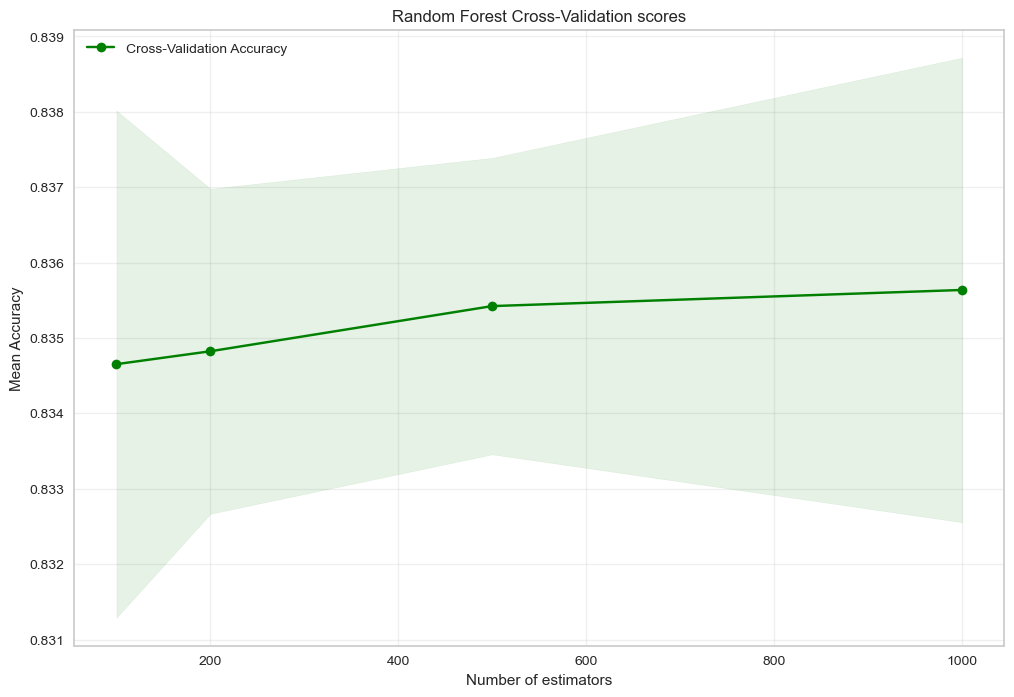

In [20]:
# Plot validation Curve for RF
plt.figure(figsize = (12, 8))
plt.plot([100, 200, 500, 1000], rf_cv.cv_results_['mean_test_score'], 'o-', color = 'green', label = 'Cross-Validation Accuracy')
plt.fill_between([100, 200, 500, 1000], rf_cv.cv_results_['mean_test_score'] - rf_cv.cv_results_['std_test_score'], rf_cv.cv_results_['mean_test_score'] + rf_cv.cv_results_['std_test_score'], alpha = 0.1, color= 'green')
plt.xlabel('Number of estimators')
plt.ylabel('Mean Accuracy')
plt.title('Random Forest Cross-Validation scores')
plt.legend()
plt.grid(True, alpha = 0.3)
plt.show()

While the Random Forest model performance was technically highest with 500 estimators, the improvement over models with lower numbers of estimators is very small. It is likely not worth trying to optimize the model further beyond this point.

In [21]:
models = {
    'K Nearest Neigbors (K=29)': KNeighborsClassifier(n_neighbors=29),
    'Logistic Regression': LogisticRegression(random_state=random_state, class_weight='balanced'),
    'Naive Bayes': GaussianNB(), # Naive Bayes and decision tree classifiers do not take a random_state parameter
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=500, random_state = random_state, class_weight='balanced'),
    'SVM (RBF kernel)': SVC(random_state=random_state, class_weight='balanced'),
    'SVM (Sigmoid kernel)': SVC(kernel="sigmoid", random_state = random_state, class_weight='balanced'),
    'SVM (Linear kernel)': SVC(kernel="linear", random_state = random_state, class_weight='balanced'),
    'SVM (Polynomial kernel)': SVC(kernel="sigmoid", random_state = random_state, class_weight='balanced')
}

# Cross-Validation (Supervised learning models)

This takes a long time to run -- the SVM models in particular take a long time to fit, and the logistic regression model fails to converge (though it still achieves a higher accuracy than some other models even without converging). The models do not differ dramatically in cross-validation accuracy, ranging from 71% at worst (Sigmoid and polynomial SVM kernels) to 83% at best (Random Forest)

In [22]:
cv_metrics = calculate_cv_metrics(X_train_scaled, y_train, models)

Cross-validating K Nearest Neigbors (K=29)
Avg accuracy: 0.8137

Avg precision: 0.8097

Avg recall: 0.8137

Avg F1 score: 0.81

Cross-validating Logistic Regression
Avg accuracy: 0.807

Avg precision: 0.8258

Avg recall: 0.807

Avg F1 score: 0.8114

Cross-validating Naive Bayes
Avg accuracy: 0.758

Avg precision: 0.7758

Avg recall: 0.758

Avg F1 score: 0.7631

Cross-validating Decision Tree
Avg accuracy: 0.7656

Avg precision: 0.7648

Avg recall: 0.7656

Avg F1 score: 0.7651

Cross-validating Random Forest
Avg accuracy: 0.8353

Avg precision: 0.8323

Avg recall: 0.8353

Avg F1 score: 0.8323

Cross-validating SVM (RBF kernel)
Avg accuracy: 0.8066

Avg precision: 0.8288

Avg recall: 0.8066

Avg F1 score: 0.8114

Cross-validating SVM (Sigmoid kernel)
Avg accuracy: 0.7128

Avg precision: 0.7417

Avg recall: 0.7128

Avg F1 score: 0.7204

Cross-validating SVM (Linear kernel)
Avg accuracy: 0.7919

Avg precision: 0.8179

Avg recall: 0.7919

Avg F1 score: 0.7973

Cross-validating SVM (Polynomi

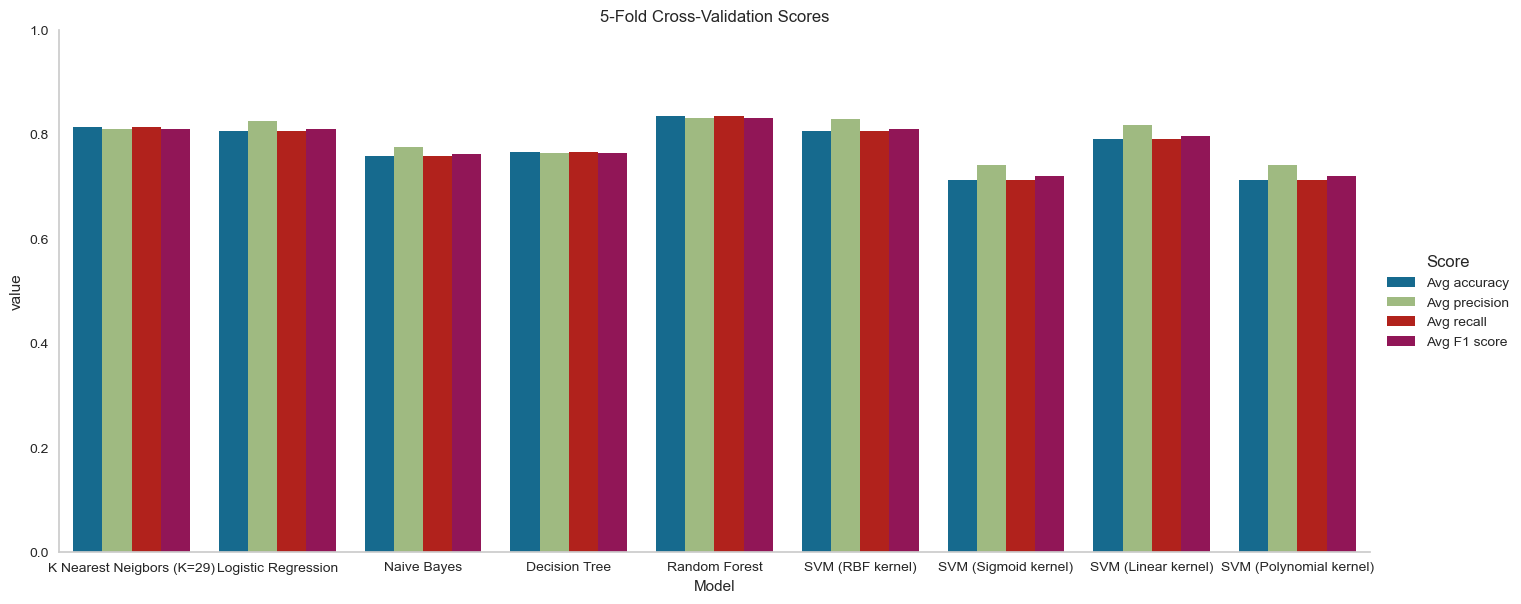

In [23]:
# Plot CV results
cv_results = pd.DataFrame(cv_metrics).reset_index()
cv_results = pd.melt(cv_results, id_vars='index', value_vars=models.keys())
cv_results.columns = ['Score', 'Model', 'value']
ax = sns.catplot(cv_results, kind="bar", x='Model', y='value', hue='Score', height=6, aspect=14/6)
ax.set(ylim=(0,1), title="5-Fold Cross-Validation Scores")

# Test Set Performance (Supervised learning models)

In [24]:
test_metrics = calculate_test_metrics(X_train_scaled, X_test_scaled, y_train, y_test, models)

Classification report for K Nearest Neigbors (K=29):

              precision    recall  f1-score   support

      Failed       0.74      0.64      0.69      3261
  Successful       0.84      0.89      0.87      6755

    accuracy                           0.81     10016
   macro avg       0.79      0.77      0.78     10016
weighted avg       0.81      0.81      0.81     10016

Classification report for Logistic Regression:

              precision    recall  f1-score   support

      Failed       0.66      0.83      0.74      3261
  Successful       0.90      0.80      0.85      6755

    accuracy                           0.81     10016
   macro avg       0.78      0.81      0.79     10016
weighted avg       0.83      0.81      0.81     10016

Classification report for Naive Bayes:

              precision    recall  f1-score   support

      Failed       0.61      0.74      0.67      3261
  Successful       0.86      0.77      0.81      6755

    accuracy                           0

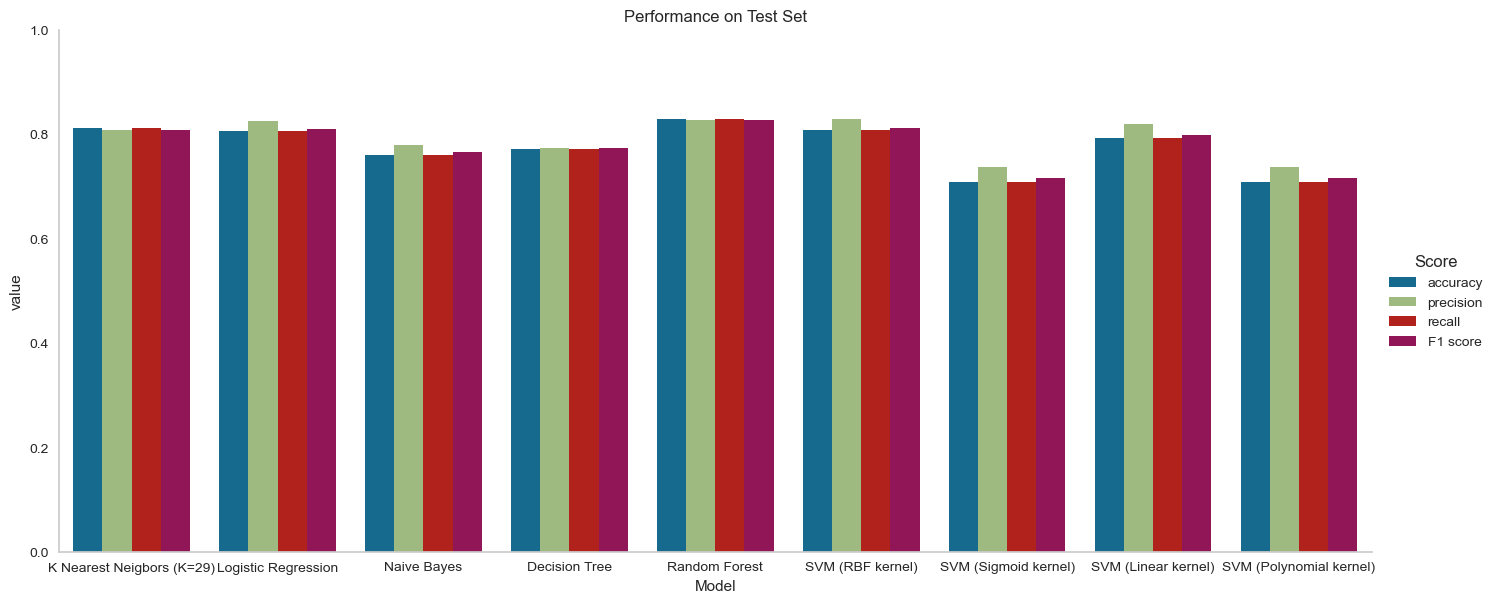

In [25]:
# Plot test set performance
test_results = pd.DataFrame(test_metrics).reset_index()
test_results = pd.melt(test_results, id_vars='index', value_vars=models.keys())
test_results.columns = ['Score', 'Model', 'value']
ax_test = sns.catplot(test_results, kind="bar", x='Model', y='value', hue='Score', height=6, aspect=14/6)
ax_test.set(ylim=(0,1), title="Performance on Test Set")

The Random Forest model had the highest testing accuracy, at 83%, but a considerably higher false-positive rate than the SVM model with RBF kernel (which had fewer false positives, but more false negatives). This is easier to see in the confusion matrices displayed below.

In this business context, false positives are more risky than false negatives, since a user could invest time and money into their Kickstarter campaign if given a prediction that it would succeed, which they would then lose if the campaign in fact failed. Choosing not to launch a Kickstarter campaign is less risky (and the user will never know if the campaign would have succeeded, so cannot blame the model for providing a false prediction). For this reason, I decided to implement the SVM model, rather than random forest, for my Streamlit application.

Confusion matrix for Random Forest classifier


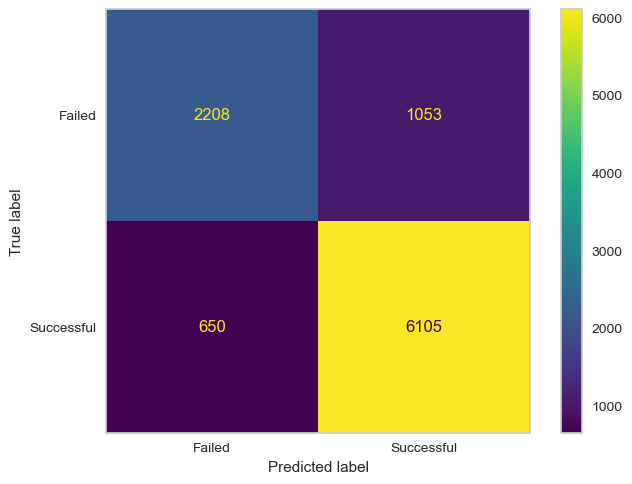

In [26]:
plt.rcParams['axes.grid'] = False # Disable grid lines
print("Confusion matrix for Random Forest classifier")
ConfusionMatrixDisplay.from_estimator(RandomForestClassifier(n_estimators=500, random_state=random_state, class_weight='balanced').fit(X_train_scaled, y_train), X_test_scaled, y_test, display_labels=['Failed','Successful'])

Confusion matrix for SVM with RBF kernel


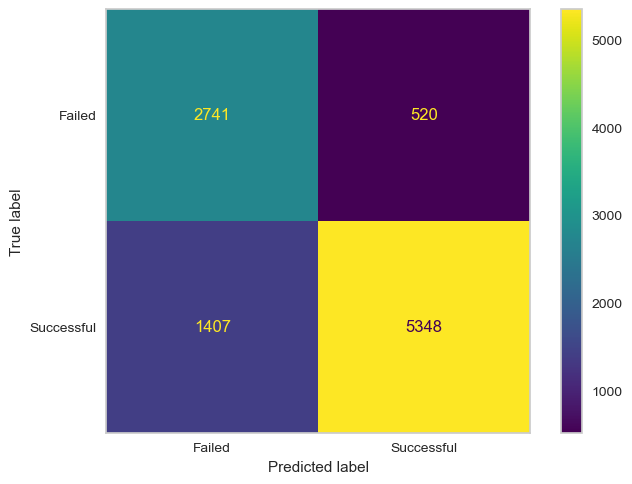

In [27]:
print("Confusion matrix for SVM with RBF kernel")
ConfusionMatrixDisplay.from_estimator(SVC(random_state=random_state, class_weight='balanced').fit(X_train_scaled, y_train), X_test_scaled, y_test, display_labels=['Failed','Successful'])

# K-Means Clustering

Use the elbow method to find the best K-Means value:

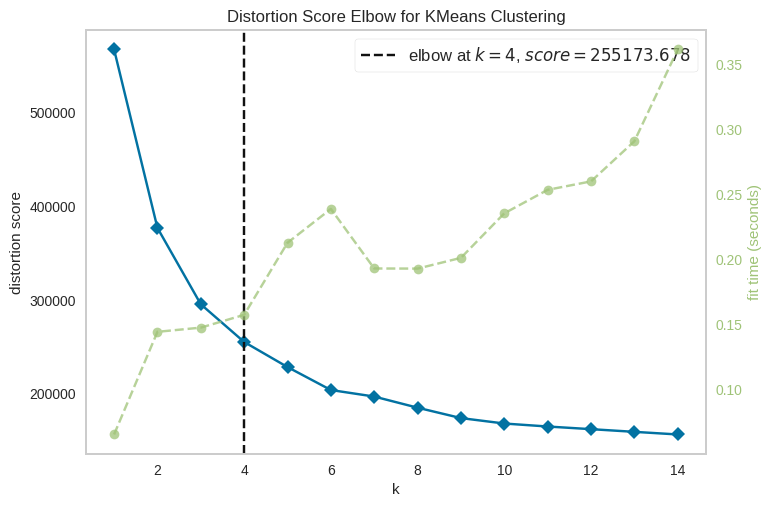

In [92]:
# K-Means elbow method
kmeans_model = KMeans(random_state=random_state)
visualizer = KElbowVisualizer(kmeans_model, k=(1, 15))
visualizer.fit(X_train_scaled)
visualizer.show()
plt.show()

We know (because there are two categories for the target value) that the "correct" number of clusters for the classification task is two, but the yellowbrick visualizer identifies 4 as the optimal number. I'll briefly look at the four-cluster solution before the two-cluster version.

In [48]:
kmeans_model = KMeans(random_state=random_state, n_clusters=4)
kmeans_model.fit_predict(X_train_scaled)

# coordinates of cluster center
centroids = kmeans_model.cluster_centers_

# cluster label for each data point
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train, kmeans_model.labels_))

[[ 4001    69     5  3533]
 [12548  1181   110  1922]
 [    0     0     0     0]
 [    0     0     0     0]]


So it looks like clusters 0, 1, and 2 are primarily successful projects, and cluster 3 is primarily failed projects. If we used that as a classification rule, we'd have (4001+69+9) = 4079 false positives, 3533 true negatives, 1922 false negatives, and (12548 + 1181 + 110) = 13839 true positives, for an accuracy of 74.3%. This is worse than most (but not all) of the classification algorithms tested above.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7608
           1       0.67      1.00      0.81     15761

    accuracy                           0.67     23369
   macro avg       0.34      0.50      0.40     23369
weighted avg       0.45      0.67      0.54     23369



<Axes: >

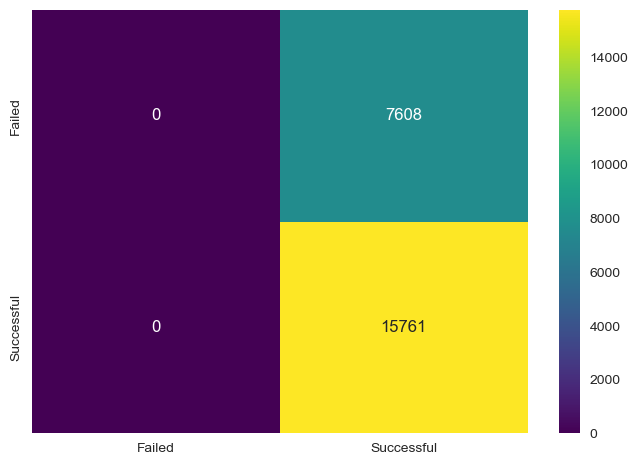

In [73]:
kmeans_train_pred = np.where(kmeans_model.labels_ == 3, 0, 1)
print(classification_report(y_train, kmeans_train_pred))
sns.heatmap(confusion_matrix(y_train, kmeans_train_pred), 
            annot=True, fmt='d', cmap='viridis',
            xticklabels=['Failed','Successful'],
            yticklabels=['Failed','Successful'])

Performance on the test set using this classification method is similarly poor. In particular, the false positive rate is very high, which is a major issue for this business scenario.

              precision    recall  f1-score   support

           0       0.64      0.45      0.53      3261
           1       0.77      0.88      0.82      6755

    accuracy                           0.74     10016
   macro avg       0.71      0.66      0.68     10016
weighted avg       0.73      0.74      0.73     10016



<Axes: >

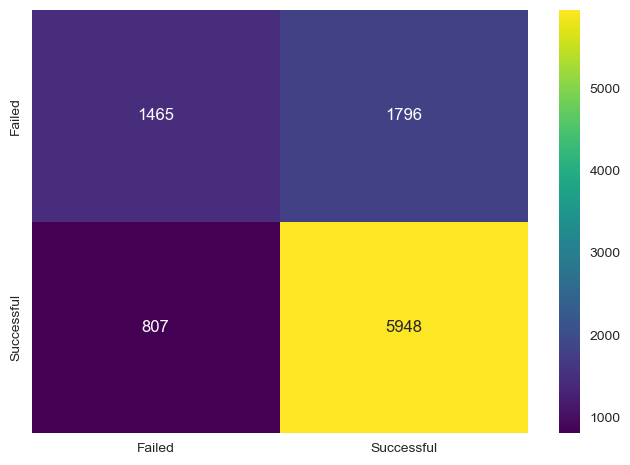

In [62]:
kmeans_predictions = kmeans_model.predict(X_test_scaled)

kmeans_categories = np.where(kmeans_predictions==3, 0, 1)
print(classification_report(y_test, kmeans_categories))
sns.heatmap(confusion_matrix(y_test, kmeans_categories), 
            annot=True, fmt='d', cmap='viridis',
            xticklabels=['Failed','Successful'],
            yticklabels=['Failed','Successful'])

In [74]:
kmeans_model = KMeans(random_state=random_state, n_clusters=2)
kmeans_model.fit_predict(X_train_scaled)
print(confusion_matrix(y_train, kmeans_model.labels_))

[[ 7575    33]
 [15260   501]]


The two-cluster model performs extremely poorly in separating successful and failed projects -- almost all the data is placed in the first cluster. If we were to consider this cluster a "successful" label, the accuracy would be only 0.65, worse than every classification model tested.

In [75]:
print(classification_report(y_train, np.where(kmeans_model.labels_==0, 1, 0)))

              precision    recall  f1-score   support

           0       0.06      0.00      0.01      7608
           1       0.67      0.97      0.79     15761

    accuracy                           0.65     23369
   macro avg       0.37      0.49      0.40     23369
weighted avg       0.47      0.65      0.54     23369



Although I selected the SVM model  with RBF kernel for my Streamlit app due to the lower false positive rate, the kernel transformation means that feature importances cannot be easily extracted for that model. For some context, here are the most important features in the Random Forest model:

In [77]:
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
     'feature': X_train_scaled.columns,
     'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance.head(10)

,feature,importance
90,usd_goal,0.146381
92,days_active,0.083491
87,blurb_length,0.069693
61,staff_pick_True,0.067191
62,prelaunch_activated_True,0.065312
89,creator_prev_projects,0.057943
88,hours_from_noon,0.057353
49,sub_category_infrequent_sklearn,0.042801
45,sub_category_Tabletop Games,0.020509
6,has_video_True,0.015150
